# Synthetic surface classification 
In this notebook we show how to integrate $2$- forms in $\mathbb{R}^n$ over the $2$-simplices of a complex and use this method to classify surfaces in $\mathbb{R}^3$

# Final example notebook 

### Theory 

A $2$-form in $\mathbb{R}^n$, denoted by $\omega \in \Omega^2(\mathbb{R}^n)$ can be written as $$\omega = \sum_{1\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$$
where $f_{i,j}: \mathbb{R}^n\longrightarrow \mathbb{R}^N$, with $N = \binom{n}{2} $ are smooth maps. 

**remark 1:** this means that we can train a neural network $\mathbb{R}^n \longrightarrow \mathbb{R}^N$ to learn $2$-forms on $\mathbb{R}^n$.

##### Integrating a $2$-form on a 2-simplex:
Denote by $\Delta$ the standard $2$-simplex in $\mathbb{R}^2$ with vertices $(0,0), (1,0), (0,1)$.
A $2$-simplex $\sigma$ in $\mathbb{R}^n$ is obtained as the embedding of $\Delta$ via a map $\varphi: \Delta \longrightarrow \mathbb{R}^n$, $\sigma = \varphi(\Delta)$. Thus to integrate the $2$-form $\omega$ on $\sigma$ one can use the identity: 
$$ \int_{\varphi(\Delta)}\omega = \int_{\Delta}\varphi^{*}\omega$$

To obtain a $2$-cochain on an embedded simplicial complex, one integrates the $2$-form on each $2$-simplex. 


**remark 2:** In more generality one can learn any $k$-form on $\mathbb{R}^n$ and integrate it on a $k$-simplex.   

### Algorithmically : 

To compute the integral on a simplex one must make an approximation in the following way. 
1. subdivide $\Delta$ into $m^2$ $2$-simplices $\mathcal{S} = \{s_l\}_{0\leq l \leq m^2}$ of equal area 
2. Denote by $V$ the set of vertices in the subdivision of $\Delta$
3. For any $p\in \Delta$ one can evaluate $\omega$ at that point and get a map $g: \Delta \rightarrow \mathbb{R}$ in the following way:
$$ g(p) = \sum_{i<j} f_{i,j}(\varphi(p))dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
4. In particular to approximate the contribution of a $2$-simplex $s\in\mathcal{S}$ to the integral one averages the value of $g(p)$ on each of its vertices $p$. Overall each vertex will contribute with weight
    - 1 if $p\in\{(0,0),(1,0),(0,1)\}$
    - 3 if $p$ is in the interior of an edge of $\Delta$
    - 6 if $p$ is in the interior of $\Delta$

    to the approximating sum below : 
5. By reordering the terms we get the following expression for the integral 
$$ \int_{\varphi(\Delta)} \omega = \frac{1}{m^2} \sum_{p\in V} |cof(p)|\cdot g(p) \cdot vol(\varphi(\Delta))$$ 


To compute $$dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
one does the following: 


<span style="color: red;">  FILLLL </span>


In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special
import neural_kforms as kf
import k_forms_visual as vis 
import pickle
import torch.optim as optim
%load_ext autoreload
%autoreload 2

# 1. Generate the data  

##### We generate synthetic surfaces by embedding a triangulated unit square in $\mathbb{R}^3$. First we build the underlying simplicial complex. 

In [2]:
def unit_square_grid(n=3):
    """
    Make a grid of points in the unit square [0,1] x [0,1]

    Parameters:
    n : int
        The number of points in each direction
    """
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)
    return np.array([X.flatten(), Y.flatten()]).T

def plot_unit_square_grid(n=3):
    """ 
    Plot the alpha complex of a grid in the unit square
    Return: the points and the alpha complex
    """
    pts = unit_square_grid(n)
    ac = gd.AlphaComplex(pts).create_simplex_tree()
    plt.scatter(pts[:,0], pts[:,1])

    for s in ac.get_skeleton(2):
        if len(s[0]) == 2: 
            plt.plot(pts[s[0], 0], pts[s[0], 1], 'r-')
    return pts, ac


there are 32 2-simplices in the triangulation


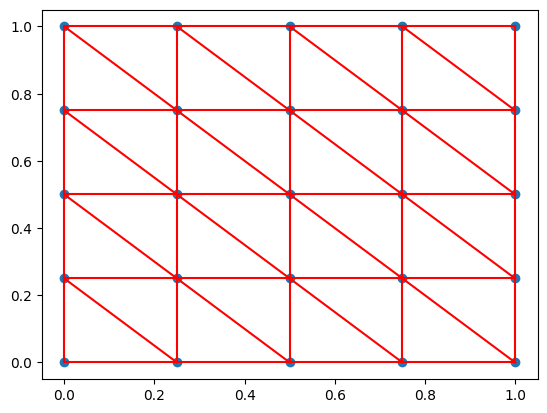

In [3]:
num_pts = 5
# Triangulate the unit square 
pts , ac = plot_unit_square_grid(num_pts)
simplices = []

## retain only the 2-simplices in a list
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])
print("there are {} 2-simplices in the triangulation".format(len(simplices)))

##### Then we randomly generate surfaces in $\mathbb{R}^3$ in two different classes. 

In [4]:
def random_surface_sin_x(n, scale = 1, period = 1, eps = 0.1):
    """ 
    Generate a random surface in R^3 with a sine wave in the x direction

    Input: 
        n: number of points in each direction
        scale: scale of the surface
        period: period of the sine wave
        eps: magnitude of the noise
    Output:
        X, Y, Z: the coordinates of the surface
        ar: an array of points    
    """

    trans_x = np.random.uniform(-10, 10, 1) # translation in x direction
    trans_y = np.random.uniform(-10, 10, 1) # translation in y direction 

    x = np.arange(0, n, 1)/scale + trans_x # x coordinates
    y = np.arange(0, n, 1)/scale + trans_y # y coordinates

    Eps = np.random.uniform(-eps,eps, (n,n)) # noise  

    X, Y = np.meshgrid(x, y) # create a grid of points
    Z = np.zeros(X.shape) # initialize the z coordinates

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = math.sin(X[i,j]/period) 
    
    Z = Z + Eps # add noise to the surface 
    ar = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
    ar = torch.from_numpy(ar)

    return X, Y, Z, ar

def random_surface_sin_y(n, scale =1, period =1, eps = 0.1):
    """
    Generate a random surface in R^3 with a sine wave in the y direction

    Input:
        n: number of points in each direction
        scale: scale of the surface
        period: period of the sine wave
        eps: magnitude of the noise
    Output:
        X, Y, Z: the coordinates of the surface
        ar: an array of points
    """

    trans_x = np.random.uniform(-10, 10, 1)
    trans_y = np.random.uniform(-10, 10, 1)
    x = np.arange(0, n, 1)/scale + trans_x
    y = np.arange(0, n, 1)/scale + trans_y
    Eps = np.random.uniform(-eps,eps, n)    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = math.sin(Y[i,j]/period) 
            # return an array of points
    Z = Z + Eps      
    ar = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
    ar = torch.from_numpy(ar)

    return X, Y, Z, ar


def generate_surfaces_sin_x(num_surf, n_pts, scale =1, period =1, eps = 0.1): 
    """
    Generate a list of random surfaces in R^3 with a sine wave in the x direction

    Input:
        num_surf: number of surfaces to generate
        n_pts: number of points in each direction
        scale: scale of the surface
        period: period of the sine wave
        eps: magnitude of the noise
    Output:
        surfaces: a list of num_surf surfaces 
    """
    surfaces = []
    for i in range(num_surf):
        surfaces.append(random_surface_sin_x(n_pts, scale = scale, period = period, eps = eps))
    return surfaces

def generate_surfaces_sin_y(num_surf, n_pts, scale =1, period =1, eps = 0.1): 
    """
    Generate a list of random surfaces in R^3 with a sine wave in the y direction
    
    Input:
        num_surf: number of surfaces to generate
        n_pts: number of points in each direction
        scale: scale of the surface
        period: period of the sine wave
        eps: magnitude of the noise
    Output:
        surfaces: a list of num_surf surfaces 
    """

    surfaces = []
    for i in range(num_surf):
        surfaces.append(random_surface_sin_y(n_pts, scale = scale, period = period, eps = eps))
    return surfaces

In [5]:
num_surf = 30

s0 = generate_surfaces_sin_x(num_surf, num_pts)
s1 = generate_surfaces_sin_y(num_surf, num_pts)

surfaces = s0 + s1 

# generate labels
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

print( "There are {} surfaces in the data set".format(len(surfaces_shuffled)))

There are 60 surfaces in the data set


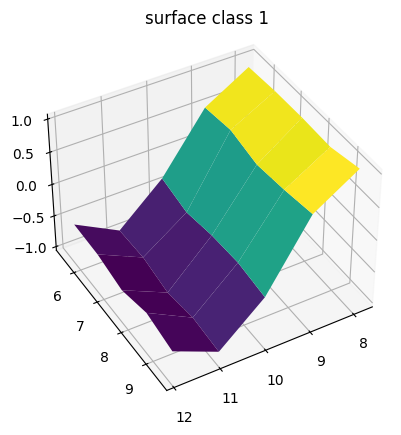

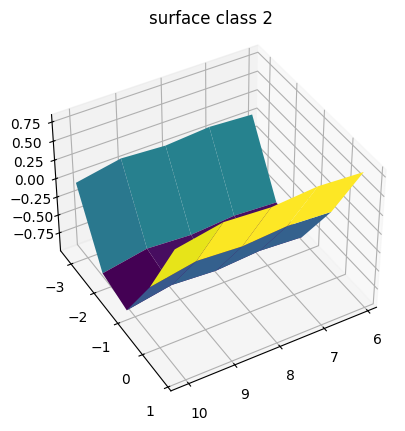

In [6]:
from neural_k_forms.plotting import plot_surface

# plot example of surfaces from each class
X1,Y1,Z1,_ = s0[0]
X2,Y2,Z2,_ = s1[0]
plot_surface(X1,Y1,Z1, title = 'surface class 1')
plot_surface(X2,Y2,Z2, title = 'surface class 2')

##### Reformating each surface into a dictionary for easier use later: 
- `'simplices'` contains the 2-simplices of the underlying abstract simplicial complex 
- `'Phi'` contains the linear part of the embedding for each 2-simplex
- `'b'` contains the affine part of the embedding for each 2-simplex
- `'points'` contains an array of the coordinates of the vertices in $\mathbb{R}^3$

In [9]:
def phi_b(embedded_vertices):
    """build the affine transforamtion matrix that corresponds to the embedded vertices"""
    #dim = embedded_vertices.shape[1] 
    
    a = [embedded_vertices[i] - embedded_vertices[0] for i in range(1,3)]
    phi = torch.stack(a)
    b = embedded_vertices[0] 
    
    return phi.float(), b.float()

In [10]:
## making dictionaries out of the surfaces
surfaces_list = []
for surf in range(num_surf*2): 
    surface = surfaces[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices

    translation = torch.tensor(np.random.uniform(-10, 10, 3))
    
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []
    

    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = phi_b(emb_vertices_simplex )
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list.append(surface_dict)

surfaces_list_shuffled = [surfaces_list[i] for i in shuffled_indices]

# 2. Classification 

In [18]:
def build_determinant_tensor(dim, k=2):
    """Input: n the number of subdivision of the simplex
        k the dimension of the simplex, default is 2 for now
    Output: Tensors of size (n choose k) x n x n that can be used to
    compute the determinant entering in the integration formula
    of  k-form over an embedded simplex
    """

    N = int(scipy.special.binom(dim, k))
    deter_tensor = torch.zeros(N, dim, dim)
    ind = 0
    for i in range(dim):
        for j in range(i + 1, dim):
            # each tensor is a nxn matrix with (i,j)-coordinate equal to
            # 1 and (j,i)-coordinate equal to -1
            deter_tensor[ind, i, j] = torch.tensor(1)
            deter_tensor[ind, j, i] = torch.tensor(-1)
            ind += 1

    return deter_tensor.float()


def is_interior(point):
    """
    check if a point is strictly in the interior of a triangle with vertices (0,0), (1,0), (0,1)
    """
    if point[0] > 0 and point[1] > 0 and point[0] + point[1] < 1:
        return True
    else:
        return False


def is_edge(point):
    """
    check if a point is on the edge of a triangle with vertices (0,0), (1,0), (0,1)
    """

    if point[0] == 0 and point[1] > 0 and point[1] < 1:
        # vertical edges
        return True
    elif point[0] > 0 and point[0] < 1 and point[1] == 0:
        # horizontal edge
        return True
    elif (
        point[1] > 0
        and point[1] < 1
        and point[0] > 0
        and point[0] < 1
        and point[0] + point[1] == 1
    ):
        # diagonal edge
        return True
    else:
        return False


def is_vertex(point):
    """
    check if a point is a vertex of a triangle with vertices (0,0), (1,0), (0,1)
    """
    if point[0] == 0 and point[1] == 0:
        return True
    elif point[0] == 1 and point[1] == 0:
        return True
    elif point[0] == 0 and point[1] == 1:
        return True
    else:
        return False


def coef_vertex(v):
    """
    Compute contribution of a vertex of the subdivision in the integration formula

    If the vertex is in the interior, the vertex is part of 6 2-simplices
    If the vertex is on an edge, the vertex is part of 3 2-simplices
    If the vertex is a vertex, the vertex is part of 1 2-simplex
    """

    if is_interior(v):
        return torch.tensor([6]).float()
    if is_edge(v):
        return torch.tensor([3]).float()
    if is_vertex(v):
        return torch.tensor([1]).float()


def subdivide_simplex_coef_torch(n):
    """
    Input: n the number of subdivision of the simplex
    Output: a list of vertices of the subdivision of the simplex and the coefficients for the contribution of each vertex
    """
    vertices = []
    for i in range(n + 1):
        for j in range(n + 1 - i):
            vertices.append([i / n, j / n])
    vertices = torch.tensor(vertices)

    coefs = []
    for i in range(len(vertices)):
        coefs.append(coef_vertex(vertices[i]))

    return vertices, coefs

In [19]:
k = 2 # degree of the k-forms
dim = 3 # dimension of the embedding space

# some things to precompute for integration 
det = build_determinant_tensor(dim, k) # tensor needed for a step in integration of 2-forms

num_sub = 2 # number of subdivision of each 2-simplex for approximating the integral of the 2-forms
vertices, coefs = subdivide_simplex_coef_torch(num_sub) 

##### We learn two 2-forms in $\mathbb{R}^3$. Recall that a 2-form can be written as $$\omega = \sum_{1\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$$ where $f_{i,j}: \mathbb{R}^n\longrightarrow \mathbb{R}^N$ are smooth maps and $N = \binom{n}{2}$. This means that we can train a neural network with input layer of size $n$ and final layer of size $N$ to learn a 2-form. To learn $l$ 2-forms we can train a neural network with final layer of size $N\cdot l$.

In [20]:
classes = 2
num_kforms = 2 ## number of k-forms to learn 
N = int(scipy.special.binom(dim,k)) 

# MLP to learn 2-forms 
kforms = nn.Sequential(
    nn.Linear(dim, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, N*num_kforms)
)

#### Train the MLP above and integrate its output to obtain cochains on the simplicial complexes (surfaces embedded in $\mathbb{R}^3$). The obtained cochains classify the surfaces into two classes

In [23]:
def forms_to_cochains(
    kform,
    surface_dict,
    deter_tensor,
    subdivision_vert,
    subdivision_coef,
    num_sub,
    l=1,
    dim=3,
    k=2,
):
    """
    From l 2-forms we get l cochains on the complex by integrating the forms over every 2-simplex in the simplicial complex

    Input:
        kform: l 2-forms
        surface_dict: a dictionary containing all of the information of the triangulated surface in R^dim
        deter_tensor: the tensor computed by build_determinant_tensor
        dim: the dimension of the embedding space
        k: the dimension of the form
        subivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
        num_sub: the number of subdivisions of the simplex for the approximation of the integral

    Output:
        cochains: l cochains on the simplicial complex
    """

    Emb_comp = surface_dict["points"]

    assert (
        Emb_comp.shape[1] == dim
    ), "The dimension of the embedding space is not equal to the number of columns of the matrix Emb_comp"

    cochains = torch.zeros(len(surface_dict["simplices"]), l)

    # deter_tensor = build_determinant_tensor(dim, k)
    for i in range(len(surface_dict["simplices"])):
        phi_simplex = surface_dict["Phi"][i]
        b_simplex = surface_dict["b"][i]
        cochains[i] = integrate_kforms(
            kform,
            phi_simplex,
            b_simplex,
            deter_tensor,
            subdivision_vert,
            subdivision_coef,
            num_sub,
            l,
            dim,
            k,
        )[:, 0].float()
    return cochains.float()


def integrate_kforms(
    kform,
    phi,
    b,
    det,
    subdivision_vert,
    subdivision_coefs,
    num_sub,
    l=1,
    dim=3,
    k=2,
):
    """Integrate multiple 2-forms over a 2-simplex
    --------
    Input:
        kform: l 2-forms
        phi: a matrix containing the embedding of the vertices of the simplex in R^dim
        b: a vector containing the embedding of the basepoint of the simplex in R^dim
        det: the tensor computed by build_determinant_tensor
        l: the number of 2-forms to integrate
        dim: the dimension of the embedding space
        k: the dimension of the form
        subdivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
        num_sub: the number of subdivisions of the simplex
    Output:
        integral: the value of integral of the l 2-forms over the 2-simplex
    """

    ## number of vertices in the subdivision
    num_simplices = int(
        num_sub**2
    )  ## number of simplices in the subdivision

    N = int(scipy.special.binom(dim, k))

    integrals = torch.zeros(l, 1)

    for i in range(l):
        ## integrate the i-th k-form
        for j in range(len(subdivision_vert)):
            p = subdivision_vert[j]
            phi_p = phi.T @ p + b
            g_p = torch.tensor([0]).float()
            for ind in range(i * N, (i + 1) * N):
                m = ind - i * N
                # print('m:',m)
                # print('ind: ',ind)
                # print('kform: ',kform(phi_p)[ind])

                g_p += kform(phi_p)[ind] * torch.matmul(
                    torch.matmul(phi[0], det[m]), phi[1].T
                )

            cof = subdivision_coefs[j]

            integrals[i] += torch.mul(g_p, cof)

        vol = torch.tensor([1 / (2 * (num_sub**2))]).float()

    return ((vol / num_simplices) * integrals).float()

In [24]:
epochs = 4

lr = 1e-1 # learning rate 

optimizer = optim.SGD(kforms.parameters(), lr) 

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

Accuracies = []
Losses= []

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = forms_to_cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_kforms, dim, k) ## integrate the learned 2-forms to obtain cochains on the simplicial complex 
        X = torch.reshape(X, (len(surface_dict['simplices']), num_kforms))
        X.retain_grad() 
        X = X.sum(0)
        X.retain_grad()
    
        sm = torch.nn.functional.softmax(X)    # softmax classifier 
        loss = criterion(sm,l) 
        print("loss: ", loss)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))
    Accuracies.append(100 * correct / total)
    Losses.append(loss)

    print('-----------')
    print('***********')
    print('-----------')



epoch:  0


/tmp/ipykernel_601400/3822100634.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  torch.matmul(phi[0], det[m]), phi[1].T
/tmp/ipykernel_601400/1653615779.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)    # softmax classifier
/tmp/ipykernel_601400/1653615779.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


loss:  tensor(0.7019, grad_fn=<DivBackward1>)
number of surfaces processed:  0
loss:  tensor(0.6296, grad_fn=<DivBackward1>)
loss:  tensor(0.8621, grad_fn=<DivBackward1>)
loss:  tensor(0.6243, grad_fn=<DivBackward1>)
loss:  tensor(0.7352, grad_fn=<DivBackward1>)
loss:  tensor(0.6562, grad_fn=<DivBackward1>)
loss:  tensor(0.5762, grad_fn=<DivBackward1>)
loss:  tensor(0.4845, grad_fn=<DivBackward1>)
loss:  tensor(0.4457, grad_fn=<DivBackward1>)
loss:  tensor(0.4398, grad_fn=<DivBackward1>)
loss:  tensor(0.7772, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(0.4046, grad_fn=<DivBackward1>)
loss:  tensor(1.1006, grad_fn=<DivBackward1>)
loss:  tensor(0.6587, grad_fn=<DivBackward1>)
loss:  tensor(0.5033, grad_fn=<DivBackward1>)
loss:  tensor(0.4565, grad_fn=<DivBackward1>)
loss:  tensor(0.4750, grad_fn=<DivBackward1>)
loss:  tensor(0.9607, grad_fn=<DivBackward1>)
loss:  tensor(0.9899, grad_fn=<DivBackward1>)
loss:  tensor(0.6313, grad_fn=<DivBackward1>)
loss:  tensor

loss:  tensor(0.3174, grad_fn=<DivBackward1>)
loss:  tensor(0.3193, grad_fn=<DivBackward1>)
loss:  tensor(0.3193, grad_fn=<DivBackward1>)
loss:  tensor(0.3183, grad_fn=<DivBackward1>)
loss:  tensor(0.3240, grad_fn=<DivBackward1>)
loss:  tensor(0.3326, grad_fn=<DivBackward1>)
loss:  tensor(0.3213, grad_fn=<DivBackward1>)
loss:  tensor(0.3591, grad_fn=<DivBackward1>)
loss:  tensor(0.3199, grad_fn=<DivBackward1>)
loss:  tensor(0.3205, grad_fn=<DivBackward1>)
number of surfaces processed:  50
loss:  tensor(0.3183, grad_fn=<DivBackward1>)
loss:  tensor(0.3150, grad_fn=<DivBackward1>)
loss:  tensor(0.3145, grad_fn=<DivBackward1>)
loss:  tensor(0.3170, grad_fn=<DivBackward1>)
loss:  tensor(0.3217, grad_fn=<DivBackward1>)
loss:  tensor(0.3384, grad_fn=<DivBackward1>)
loss:  tensor(0.3183, grad_fn=<DivBackward1>)
loss:  tensor(0.3614, grad_fn=<DivBackward1>)
loss:  tensor(0.3388, grad_fn=<DivBackward1>)
Accuracy of the network on the 60 training surfaces at epoch 2 : 100.0 
-----------
********

# Plots

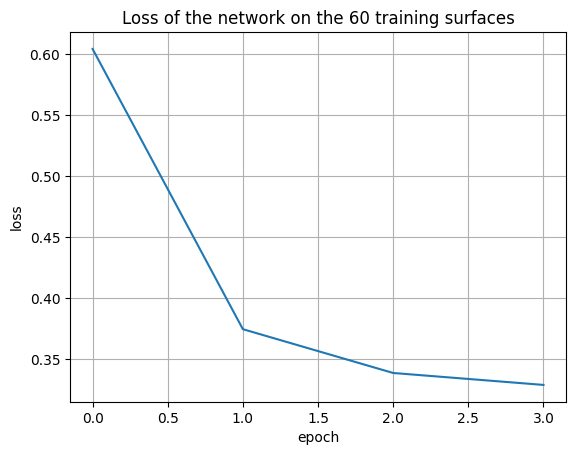

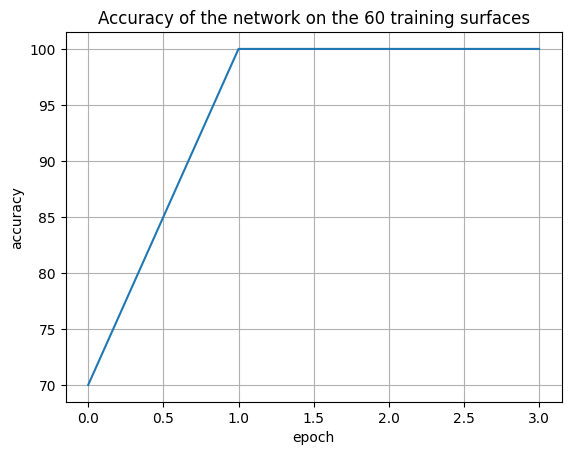

In [25]:
# plot the loss
Losses = [loss.detach() for loss in Losses]
fig, ax = plt.subplots()
ax.plot(np.arange(len(Losses)), Losses)
ax.set(xlabel='epoch', ylabel='loss', title='Loss of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

# plot the accuracy
fig, ax = plt.subplots()
ax.plot(np.arange(len(Accuracies)), Accuracies)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

In [27]:
cochains = [] #cochains obtained from the final learned 2-forms 
for i in range(len(surfaces_list)):
    surface_dict= surfaces_list[i]
    cochain = forms_to_cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_kforms, dim, k) ## multiple cochains 
    cochain = cochain.detach().numpy()
    cochains.append(cochain)


cochain0 = [cochains[i][:,0] for i in range(len(cochains))]
cochain1 = [cochains[i][:,1] for i in range(len(cochains))]

representation = np.zeros((num_surf*2, 2))
for i in range(len(cochains)):
    representation[i,0] = np.sum(cochain0[i])
    representation[i,1] = np.sum(cochain1[i])

In [ ]:

representation = np.zeros((num_surf*2, 2))
for i in range(num_surf*2):
    representation[i,0] = np.sum(cochain0[i])
    representation[i,1] = np.sum(cochain1[i])


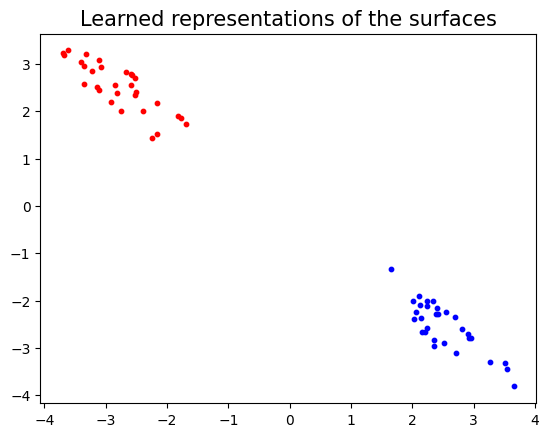

In [28]:
# plot the representation

fig, ax = plt.subplots()

for i in range(num_surf): 
    ax.scatter(representation[i,0], representation[i,1], s = 10, c='blue')
for i in range(num_surf,num_surf*2):
    ax.scatter(representation[i,0], representation[i,1], s = 10, c='red')

ax.set_title('Learned representations of the surfaces', size = 15)
plt.show()

# continue cleaning here 

In [ ]:
cochain_np= np.array(cochain1)
cochain_np = cochain_np.flatten()
min_val = cochain_np.min()
max_val = cochain_np.max()
print(min_val)
print(max_val)



edges = [] #list of 1-simplices
for s in ac.get_skeleton(2):
    if len(s[0]) == 2: 
        edges.append(s[0])


k = 1
view = (30,60)
surface = surfaces_list[k]
#color = vis.value2color_all(cochain1[k], min_val, max_val)
color = vis.value2color_all(representation[k,0], min_val, max_val)
vis.plot_surface_integral(surface, color, simplices, edges, num_pts, title = 'Class 1', view = view)
print('bla')
print(np.sum(cochain1[k]))



k = -1
view = (30,10)
surface = surfaces_list[k]
#color = vis.value2color_all(cochain1[k], min_val, max_val)
color = vis.value2color_all(representation[k,0], min_val, max_val)
vis.plot_surface_integral(surface, color, simplices, edges, num_pts, title = 'Class 2', view = view)
print(np.sum(cochain1[k]))